# Practice dissecting labels

In [1]:
import sys
sys.path.append('..')

In [2]:
import io
from functools import partial
from pathlib import Path
from tempfile import NamedTemporaryFile

# import cv2
import pytesseract
from ipywidgets import interact
import numpy as np
from skimage import filters, morphology, restoration, util
from PIL import Image as PImage, ImageDraw, ImageOps
from wand.image import Image

In [3]:
DATA_DIR = Path('..') / 'data'
LABELS_DIR = DATA_DIR / 'labels' / 'typewritten'

ON, OFF = 255, 0

In [4]:
IMAGES = sorted(LABELS_DIR.glob('*.jpg'))

### Try wand

APPALACHIAN STATE UNIVERSITY HERBARIUM
PLANTS OF costa RT AA

has hk

+ 4a? , mm + ~
LULLS (Kze.) UIP re Ve
paces

 

Qsa paninsuls near Rincon,

No. 73-79 Date 6/8/73
Collected by Rie! , OORT

Determined by R.eTrvon, Griy %



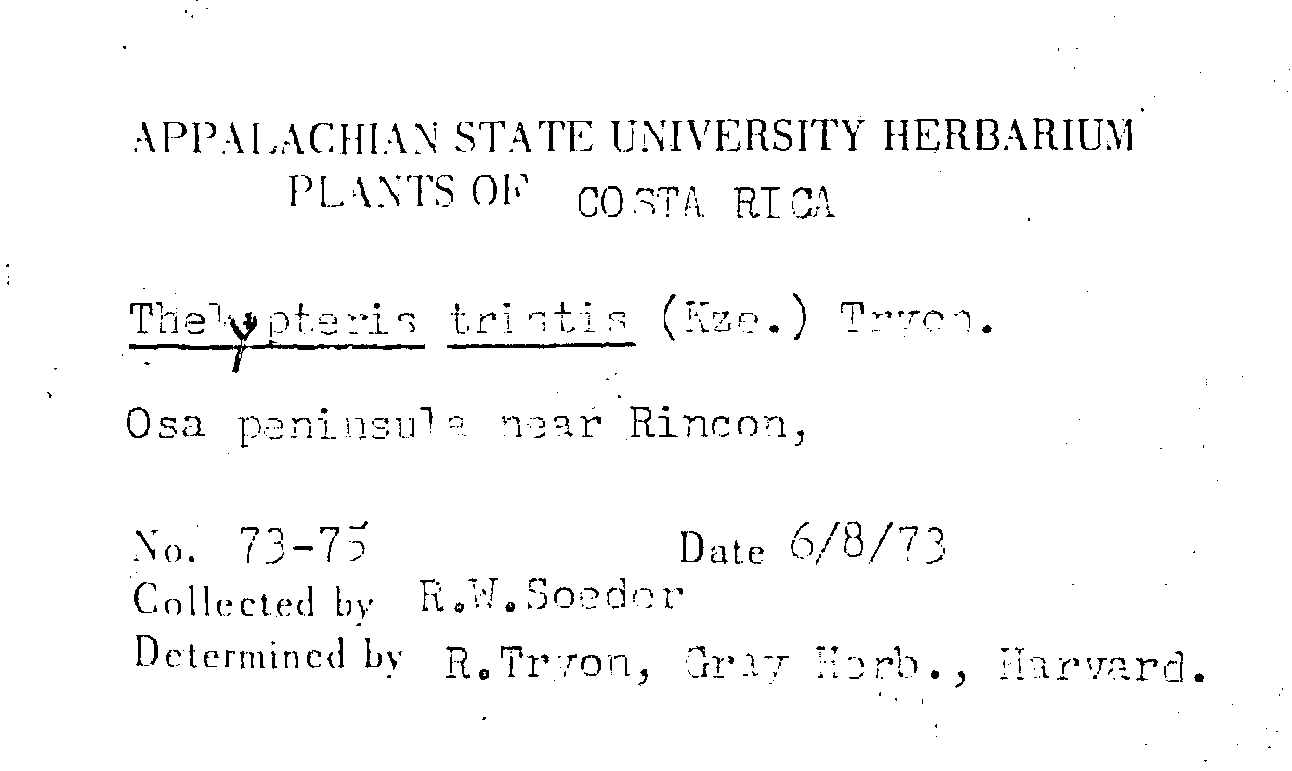

In [5]:
def wand_image(idx):
    path = IMAGES[idx]
    with Image(filename=path) as image:
        image.type = 'grayscale'
        image.adaptive_threshold(width=16, height=16, offset=-0.08 * image.quantum_range)
        blob = image.make_blob('jpeg')
        blob = PImage.open(io.BytesIO(blob))
        text = pytesseract.image_to_string(blob)
        print(text)
        display(image)


wand_image(46)

### Trying various methods for image cleanup in scikit-image

In [6]:
WAVELET = partial(restoration.denoise_wavelet, rescale_sigma=True)
SIGMA = 0.3
BLOCK_SIZE = 15

RANGES = {
    'sigma': np.arange(0.1, 0.3, 0.02),
    'wavelet': ['db1', 'db2'],
    'convert2ycbcr': [True, False],
    'multichannel': [True]
}

../data/labels/typewritten/10667427.jpg 

APPALACHIAN STATE UNIVERSITY HERBARIUM
PLANTS OF cOarA RICA

 

Osa peninsuls near Rincen,

No. 73-75 Date 6/8/73
Collected by RW, Soeder
Determined by

R.Trvon, Gray Herb. + Harvard,



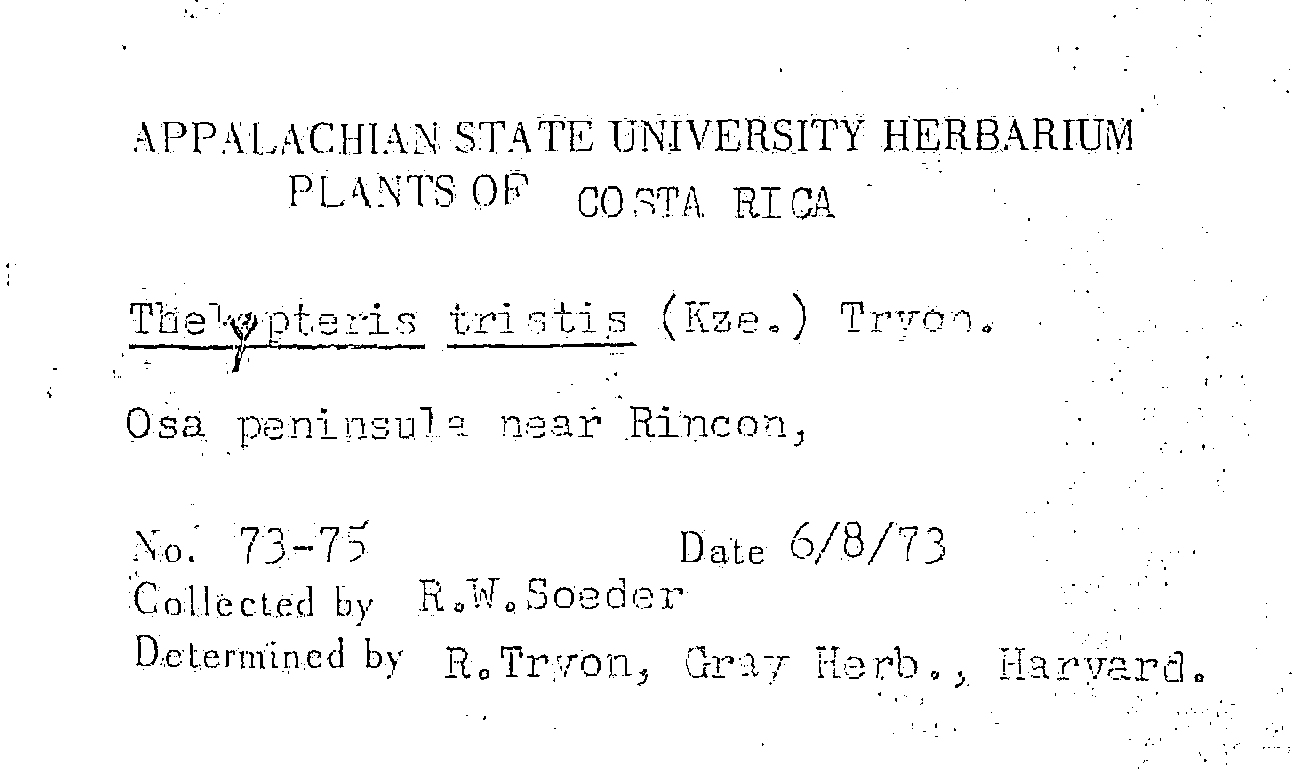

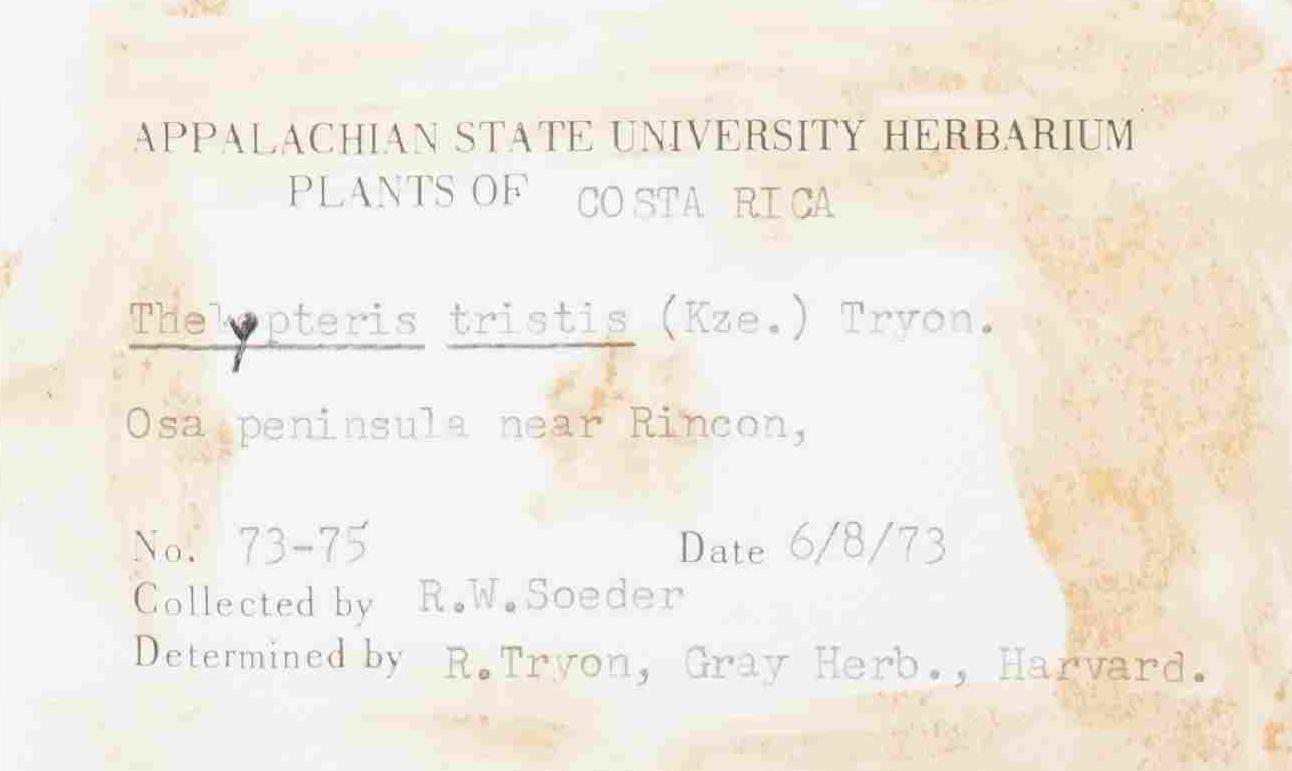

In [7]:
def skimage_image(idx):
    path = IMAGES[idx]

    image = PImage.open(path)

    # calibrated = restoration.calibrate_denoiser(
    #     image, WAVELET, denoise_parameters=RANGES)

    # denoised = calibrated(image)
    
    # gray = Image.fromarray((denoised * 255).astype(np.uint8))
    gray = image.convert('L')
    gray = np.array(gray)

    threshold = filters.threshold_local(gray, block_size=BLOCK_SIZE, offset=10)
    # threshold = filters.threshold_otsu(data)

    # binary = image.point(lambda x: OFF if x < threshold else ON)
    binary = gray > threshold

    #selem = morphology.disk(1)
    #binary = morphology.erosion(binary, selem)
    # binary = morphology.dilation(binary, selem)

    text = pytesseract.image_to_string(binary)

    print(path, '\n')
    print(text)
    display(PImage.fromarray(binary))
    display(image)


skimage_image(46)
# interact(skimage_image, idx=(0, len(IMAGES) - 1))